In [48]:
import pickle
import einops
from matplotlib import pyplot as plt
from scipy.ndimage import zoom
import numpy as np

path_attn = "attn_idx_7.pickle"

with open(path_attn, "rb") as f:
    attn_idx = pickle.load(f)

In [49]:
attn_idx[0].shape

(32, 8, 4096)

In [3]:
path_patches = "volume.pickle"

with open(path_patches, "rb") as f:
    volume = pickle.load(f)

In [4]:
volume.shape

torch.Size([1240, 752, 752])

In [5]:
aneurysm = volume[990:1020, 360:410, 300:360]

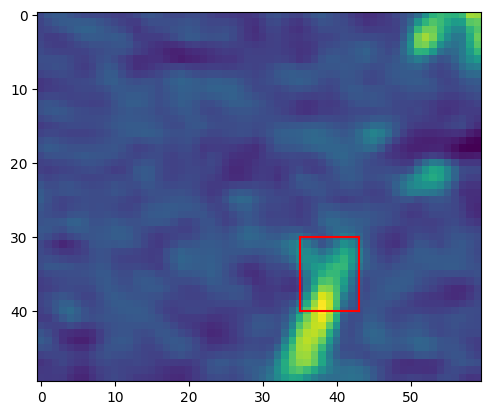

In [7]:
center = (399 - 360, 335 - 300)
size = (4 * 2, 5 * 2)
center_orig = (1007, 399, 335)

plt.imshow(aneurysm[10, :, :])
# draw bounding box arround center
plt.plot(
    [center[0] - size[0] / 2, center[0] - size[0] / 2],
    [center[1] - size[1] / 2, center[1] + size[1] / 2],
    color="r",
)
plt.plot(
    [center[0] + size[0] / 2, center[0] + size[0] / 2],
    [center[1] - size[1] / 2, center[1] + size[1] / 2],
    color="r",
)
plt.plot(
    [center[0] - size[0] / 2, center[0] + size[0] / 2],
    [center[1] - size[1] / 2, center[1] - size[1] / 2],
    color="r",
)
plt.plot(
    [center[0] - size[0] / 2, center[0] + size[0] / 2],
    [center[1] + size[1] / 2, center[1] + size[1] / 2],
    color="r",
)

In [8]:
idx_sample = 0
idx_batch = 0
idx_query = 0

In [9]:
attn_idx[0].shape

(32, 8, 4096)

In [10]:
# collapse attn_idx into nump array


attn_idx = np.concatenate(attn_idx, axis=0)
attn_idx.shape

(22464, 8, 4096)

In [11]:
crop_size = (64, 64, 64)
overlap = (32, 32, 32)

side_len = [
    crop_size[0] - overlap[0],
    crop_size[1] - overlap[1],
    crop_size[2] - overlap[2],
]

z, h, w = volume.shape

nz = int(np.ceil(float(z) / side_len[0]))
nh = int(np.ceil(float(h) / side_len[1]))
nw = int(np.ceil(float(w) / side_len[2]))

In [12]:
nz, nh, nw

(39, 24, 24)

In [13]:
idx = 0
for iz in range(nz):
    for ih in range(nh):
        for iw in range(nw):
            sz = int(iz * side_len[0])
            ez = int((iz + 1) * side_len[0] + overlap[0])
            sh = int(ih * side_len[1])
            eh = int((ih + 1) * side_len[1] + overlap[1])
            sw = int(iw * side_len[2])
            ew = int((iw + 1) * side_len[2] + overlap[2])

            idx += 1
            # check if center_orig is in this crop
            if (
                sz <= center_orig[0] < ez
                and sh <= center_orig[1] < eh
                and sw <= center_orig[2] < ew
            ):
                print("found center")
                print(idx)
                best_idx = idx
                print(iz, ih, iw)
                best_loc = (sz, ez, sh, eh, sw, ew)
                break

found center
17554
30 11 9
found center
17564
30 12 9
found center
18102
31 11 9
found center
18112
31 12 9


In [14]:
attn_sample = attn_idx[best_idx]

In [15]:
attn_rearranged = einops.rearrange(
    attn_sample, "b (d h w) -> b d h w", d=16, h=16, w=16
)
attn_zoomed = zoom(attn_rearranged, (1, 4, 4, 4))

In [16]:
coords = (
    center_orig[0] - best_loc[0],
    center_orig[1] - best_loc[2],
    center_orig[2] - best_loc[4],
)
coords

(15, 15, 47)

In [17]:
# upsample each slice

size = 64
overlap = 32

In [18]:
best_volume = volume[
    best_loc[0] : best_loc[1], best_loc[2] : best_loc[3], best_loc[4] : best_loc[5]
]

In [19]:
aneurysm_loc = [1007, 399, 335]

coords = (
    aneurysm_loc[0] - best_loc[0],
    aneurysm_loc[1] - best_loc[2],
    aneurysm_loc[2] - best_loc[4],
)

In [20]:
coords

(15, 15, 47)

0.1580273

In [37]:
argmax = attn_zoomed[0].argmax()
# translate argmax into coords
argmax = np.unravel_index(argmax, (64, 64, 64))

In [38]:
argmax

(28, 12, 59)

Text(0.5, 1.0, 'Original slice')

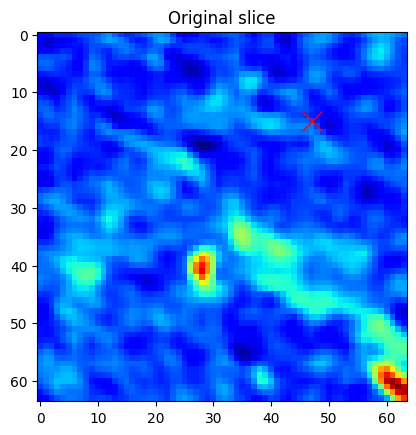

In [45]:
plt.imshow(best_volume[28, :, :], cmap="jet")
plt.plot(coords[2], coords[1], "rx", markersize=15)
plt.title("Original slice")

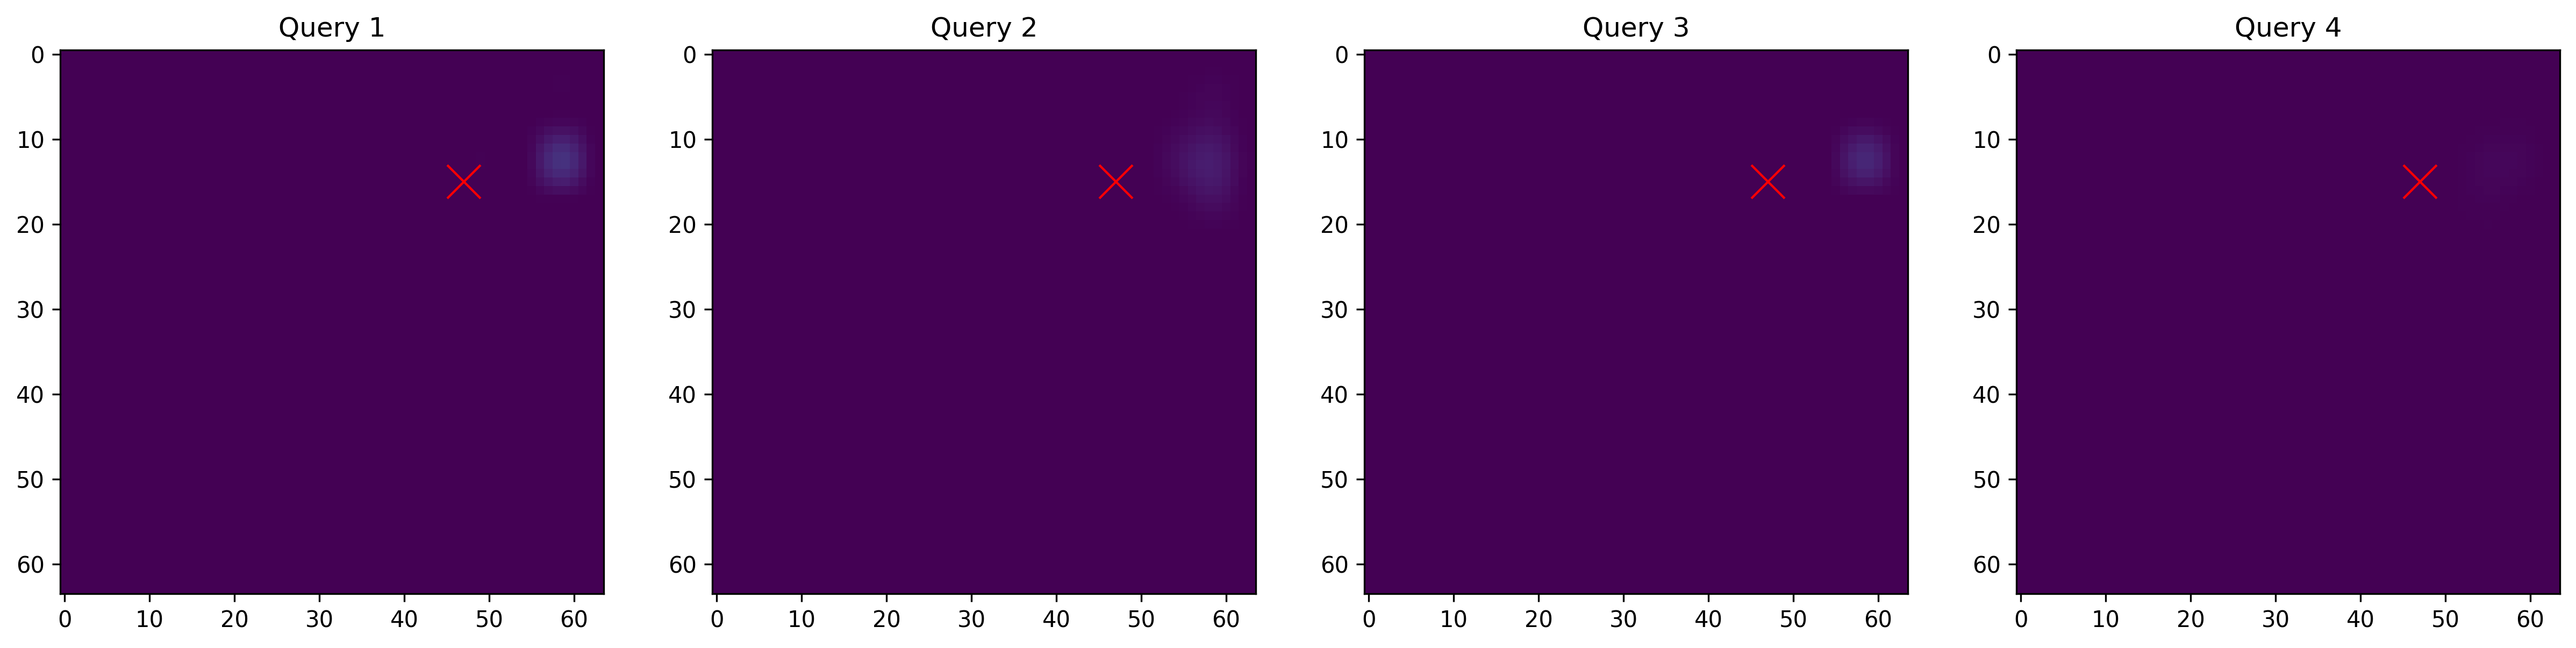

In [44]:
# plot an 8 grid varying the 0th position of attn_Zoomed
slice = 28
fig, ax = plt.subplots(1, 4, figsize=(20, 5), dpi=300)
for i in range(0, 4):
    ax[i - 4].imshow(best_volume[slice, :, :], cmap="gray")
    # overlap attn zoomed with some transparency on top
    ax[i - 4].imshow(attn_zoomed[i, slice, :, :], alpha=0.75, vmin=0, vmax=0.15)
    # ax[i].imshow(attn_zoomed[i, 15, :, :])
    ax[i - 4].set_title(f"Query {i+1}")
    # draw box around coords

    ax[i - 4].plot(coords[2], coords[1], "rx", markersize=15)

# plt.imshow(attn_zoomed[2, 15, :, :])